In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from tqdm import tqdm

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn import set_config

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectPercentile, chi2

from sklearn.metrics import r2_score, mean_squared_error,accuracy_score, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_parquet("../data/diamonds.parquet")
#df

In [3]:
#df.info()

In [4]:
#df.describe()

## Define the categories for transformations

We have numerical columns as well as categorical columns both of ordinal and nominal subtypes

#### Numerical 

In [5]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
#numerical_columns

#### Ordinals

In [6]:
ordinal_columns = ['clarity', 'culet_size', 'cut_quality', 'polish', 'symmetry']

In [7]:
clarity_ord = ['F', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1',  'SI2', 'SI3', 'I1', 'I2','I3']
culet_size_ord = ['N', 'VS', 'S', 'M', 'SL', 'L', 'VL', 'EL', 'unknown']
cut_quality_ord = ['Ideal', 'Excellent',  'Very Good', 'Good', 'Fair', 'None', 'unknown']
polish_ord = ['Excellent','Very Good', 'Good', 'Fair', 'Poor']
symmetry_ord = ['Excellent','Very Good', 'Good', 'Fair', 'Poor']

#### Nominals

In [8]:
nominal_columns = ['cut', 'color','lab','eye_clean','culet_condition',\
                   'girdle_max', 'girdle_min',\
                   'fancy_color_intensity','fancy_color_dominant_color',\
                   'fancy_color_secondary_color','fancy_color_overtone',\
                   'fluor_color', 'fluor_intensity']
            
# for col in nominal_columns:
#     print(f" '{col}' has the following values: \n \t {df[col].unique()} \n")

### From the course we know regression models don't do well with long tails. From the EDA notebook we know this has a very loooooong tail.

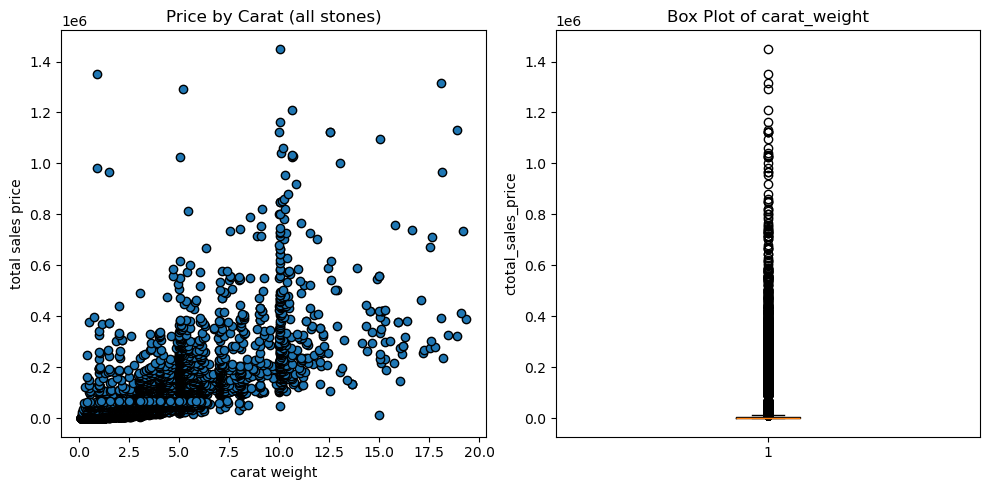

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram (price by carat weight)

ax1.scatter(x=df['carat_weight'], y=df['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat weight')
ax1.set_ylabel('total sales price')
ax1.set_title('Price by Carat (all stones)')

# Box Plot (Whiskers)
ax2.boxplot(df['total_sales_price'])
ax2.set_ylabel('ctotal_sales_price')
ax2.set_title('Box Plot of carat_weight')

plt.tight_layout()
plt.show()

In [10]:
# # Create the plot
# sns.scatterplot(x='carat_weight', y='total_sales_price', data=df, hue='carat_weight', palette='viridis')


# # Box Plot (Whiskers)
# ax2.boxplot(df['total_sales_price'])
# ax2.set_ylabel('ctotal_sales_price')
# ax2.set_title('Box Plot of total_sales_price')

### We can try splitting this with everything in the box and whiskers as one model and everything above that as another.
### AND/OR
### We can try taking the log of the prices to regularize it. It makes more sense to try in that order.

### But. But, but, but, but ... that doesn't take into account the fact that colored (aka fancy) diamonds which are natural are quite rare (and therefore expensive) but lab-grown color diamonds have a lower value. All of these *should* be natural because of the age of the dataset but, who knows?

### So, first we're going to split this by colored vs clear diamonds.

In [11]:
fancy_diamonds = df.loc[(df['fancy_color_dominant_color'] != 'unknown') & (df['color'] == 'unknown')] 

In [12]:
clear_diamonds = df.loc[(df['fancy_color_dominant_color'] == 'unknown') & (df['color'] != 'unknown')] 

In [13]:
### First question: Did I get them all?

In [14]:
fancy_cols = ['fancy_color_intensity','fancy_color_dominant_color','fancy_color_secondary_color','fancy_color_overtone']

for column in fancy_cols:
    print(f"Unique values and counts for {column}:") 
    print(clear_diamonds[column].value_counts()) 
    print("\n")

Unique values and counts for fancy_color_intensity:
fancy_color_intensity
unknown    210540
Name: count, dtype: int64


Unique values and counts for fancy_color_dominant_color:
fancy_color_dominant_color
unknown    210540
Name: count, dtype: int64


Unique values and counts for fancy_color_secondary_color:
fancy_color_secondary_color
unknown    210540
Name: count, dtype: int64


Unique values and counts for fancy_color_overtone:
fancy_color_overtone
unknown      210534
Yellowish         3
Greenish          2
Brownish          1
Name: count, dtype: int64




In [15]:
oddities = fancy_diamonds[fancy_diamonds['color'] != 'unknown']
oddities

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price


## No oddities. Nice! And a total of 6 clear diamonds with overtones of color.
#### Let's plot the two prices by carat weight for the two for the entire range, side by side

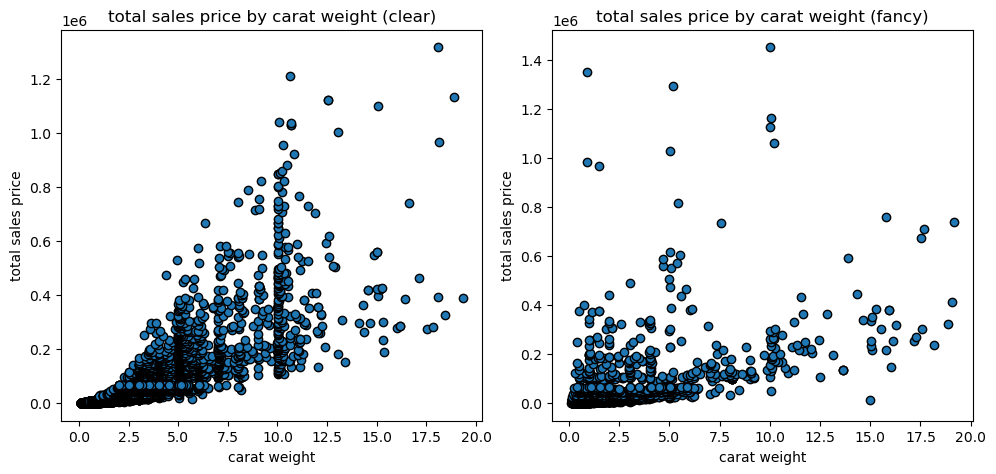

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram (price by carat weight)
ax1.scatter(x=clear_diamonds['carat_weight'], y=clear_diamonds['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat weight')
ax1.set_ylabel('total sales price')
ax1.set_title('total sales price by carat weight (clear)')


# Histogram (price by carat weight)
ax2.scatter(x=fancy_diamonds['carat_weight'], y=fancy_diamonds['total_sales_price'],  edgecolor='black')
ax2.set_xlabel('carat weight')
ax2.set_ylabel('total sales price')
ax2.set_title('total sales price by carat weight (fancy)')

# # Create the plot
# sns.scatterplot(x='carat_weight', y='total_sales_price', data=, hue='carat_weight', palette='viridis')

plt.tight_layout()
plt.show()

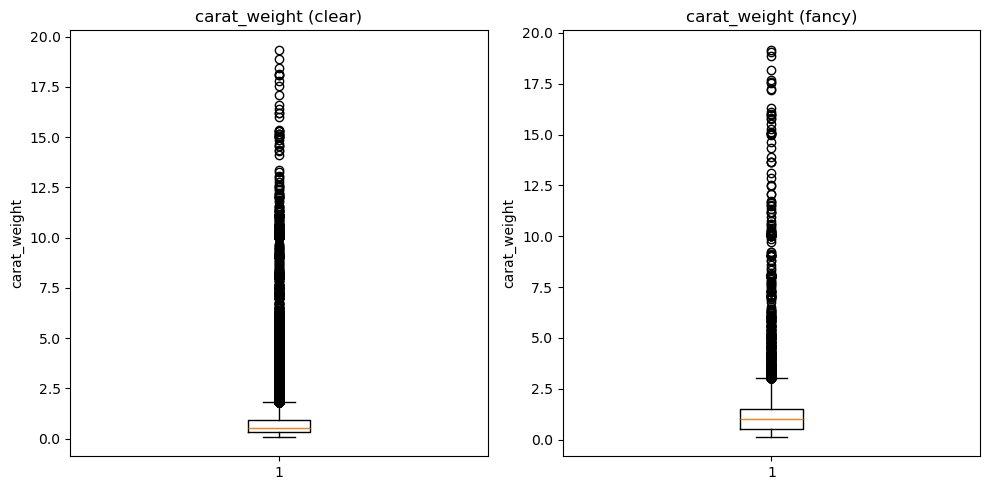

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram (price by carat weight)
ax1.boxplot(clear_diamonds['carat_weight'])
ax1.set_ylabel('carat_weight')
ax1.set_title('carat_weight (clear)')

ax2.boxplot(fancy_diamonds['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('carat_weight (fancy)')


# # Histogram (price by carat weight)
# ax2.scatter(x=fancy_diamonds['carat_weight'], y=fancy_diamonds['total_sales_price'],  edgecolor='black')
# ax2.set_xlabel('carat weight')
# ax2.set_ylabel('total sales price')
# ax2.set_title('total sales price by carat weight (fancy)')

# # Create the plot
# sns.scatterplot(x='carat_weight', y='total_sales_price', data=, hue='carat_weight', palette='viridis')

plt.tight_layout()
plt.show()

## They're different. Let's continue on to see how different by looking at where the outlier starts for each.

In [18]:
clear_Q1_price, clear_Q3_price = clear_diamonds['total_sales_price'].quantile(.25), clear_diamonds['total_sales_price'].quantile(.75)
clear_IQR_price = clear_Q3_price - clear_Q1_price
clear_upper_lim_price = clear_Q3_price + 1.5*clear_IQR_price

clear_IQR_price, clear_upper_lim_price

(np.float64(3789.5), np.float64(10417.75))

In [19]:
clear_Q1_carat, clear_Q3_carat = clear_diamonds['carat_weight'].quantile(.25), clear_diamonds['carat_weight'].quantile(.75)
clear_IQR_carat = clear_Q3_carat - clear_Q1_carat
clear_upper_lim_carat = clear_Q3_carat + 1.5*clear_IQR_carat
clear_IQR_carat, clear_upper_lim_carat

(np.float64(0.6000000000000001), np.float64(1.81))

## OK, so for clear diamonds, outliers start right above 1.81 carats or $10,417 

### Now for fancy stones

In [20]:
fancy_Q1_price, fancy_Q3_price = fancy_diamonds['total_sales_price'].quantile(.25), fancy_diamonds['total_sales_price'].quantile(.75)
fancy_IQR_price = fancy_Q3_price - fancy_Q1_price
fancy_upper_lim_price = fancy_Q3_price + 1.5*fancy_IQR_price
fancy_IQR_price, fancy_upper_lim_price

(np.float64(12959.5), np.float64(35639.25))

In [21]:
fancy_Q1_carat, fancy_Q3_carat = fancy_diamonds['carat_weight'].quantile(.25), fancy_diamonds['carat_weight'].quantile(.75)
fancy_IQR_carat = fancy_Q3_carat - fancy_Q1_carat
fancy_upper_lim_carat = fancy_Q3_carat + 1.5*fancy_IQR_carat
fancy_IQR_carat, fancy_upper_lim_carat

(np.float64(1.0), np.float64(3.01))

#### Combined, the cutoff points are (from the Models notebook):
$11,580 and 2.04 carats
   
#### Separated and for clear stones, they are:
   $10,417 and 1.81 carats.
   
#### Separated and for fancy stones, they are:
   $35,639 and 3.01 carats.

#### I've tried a combined dataset with cutoff points are $11,580 and 2.04 carats. It had a second cutoff at 6.25 carats
The best run of that was with XGBoost (no surprise) with the following evaluation Metrics for the best XGBoost Model:

	- Validation RMSE: 3938.5031
	  Validation R²: 0.7681  
	  Validation Explained Variance: 0.7681

#### Let's continue on to see if we can beat it.

In [22]:
clear_low_cw = clear_diamonds[clear_diamonds['carat_weight'] < clear_upper_lim_carat].copy()

clear_low_cw.loc[:, 'log_cw'] = np.log(clear_low_cw['carat_weight'])
clear_low_cw.loc[:, 'log_price'] = np.log(clear_low_cw['total_sales_price'])

In [23]:
clear_high_cw = clear_diamonds[clear_diamonds['carat_weight'] > clear_upper_lim_carat].copy()

clear_high_cw.loc[:, 'log_cw'] = np.log(clear_high_cw['carat_weight'])
clear_high_cw.loc[:, 'log_price'] = np.log(clear_high_cw['total_sales_price'])

In [24]:
fancy_low_cw = fancy_diamonds[fancy_diamonds['carat_weight'] < fancy_upper_lim_carat].copy()

fancy_low_cw.loc[:, 'log_cw'] = np.log(fancy_low_cw['carat_weight'])
fancy_low_cw.loc[:, 'log_price'] = np.log(fancy_low_cw['total_sales_price'])

In [25]:
fancy_high_cw = fancy_diamonds[fancy_diamonds['carat_weight'] > fancy_upper_lim_carat].copy()

fancy_high_cw.loc[:, 'log_cw'] = np.log(fancy_high_cw['carat_weight'])
fancy_high_cw.loc[:, 'log_price'] = np.log(fancy_high_cw['total_sales_price'])

### Plotting diamonds under the cutoff point (top pair is clear; bottom pair is fancy)

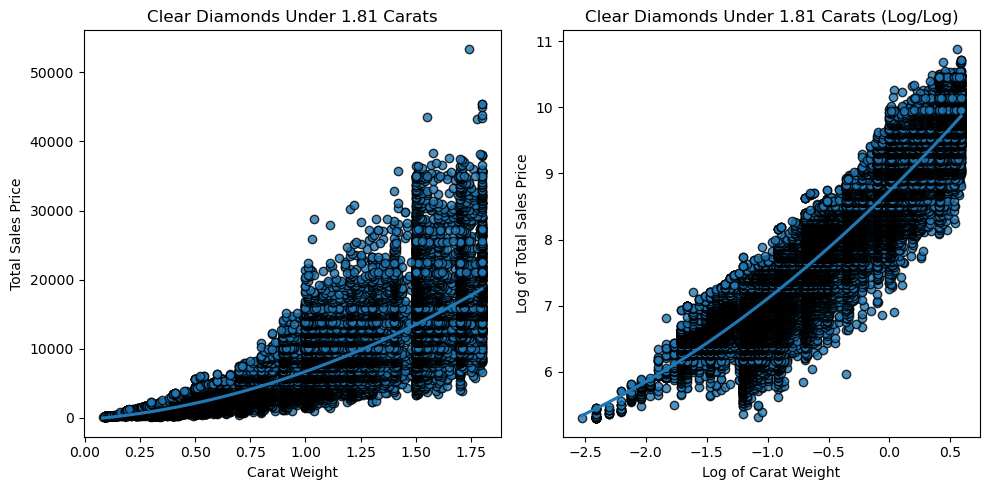

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# linear 
sns.regplot(x='carat_weight', y='total_sales_price', data=clear_low_cw, ax=ax1, scatter_kws={'edgecolor':'black'}, order=2)
ax1.set_xlabel('Carat Weight')
ax1.set_ylabel('Total Sales Price')
ax1.set_title(f'Clear Diamonds Under {clear_upper_lim_carat} Carats')

# log/log
sns.regplot(x='log_cw', y='log_price', data=clear_low_cw, ax=ax2, scatter_kws={'edgecolor':'black'})
ax2.set_xlabel('Log of Carat Weight')
ax2.set_ylabel('Log of Total Sales Price')
ax2.set_title(f'Clear Diamonds Under {clear_upper_lim_carat} Carats (Log/Log)')

plt.tight_layout()
plt.show()

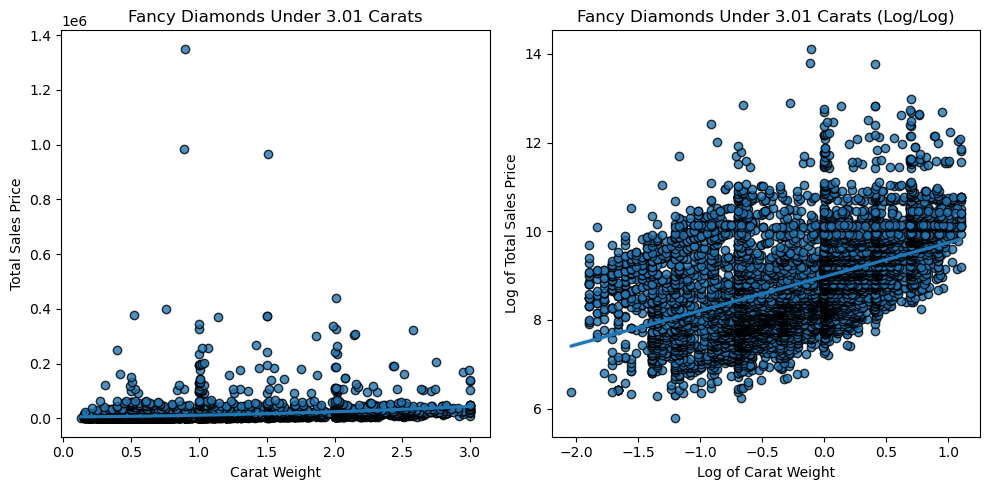

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# linear
sns.regplot(x='carat_weight', y='total_sales_price', data=fancy_low_cw, ax=ax1, scatter_kws={'edgecolor':'black'},  order=2)
ax1.set_xlabel('Carat Weight')
ax1.set_ylabel('Total Sales Price')
ax1.set_title(f'Fancy Diamonds Under {fancy_upper_lim_carat} Carats')

# log/log
sns.regplot(x='log_cw', y='log_price', data=fancy_low_cw, ax=ax2, scatter_kws={'edgecolor':'black'},  order=1)
ax2.set_xlabel('Log of Carat Weight')
ax2.set_ylabel('Log of Total Sales Price')
ax2.set_title(f'Fancy Diamonds Under {fancy_upper_lim_carat} Carats (Log/Log)')

plt.tight_layout()
plt.show()

A lot more variation for the fancy diamonds but I think still do-able. Let's see plots for above the cutoff points.

Because the extended range still has outliers (cell 17)

In [28]:
clear_high_Q1_carat_weight, clear_high_Q3_carat_weight = clear_high_cw ['carat_weight'].quantile(.25), clear_high_cw ['carat_weight'].quantile(.75)
clear_high_IQR_carat_weight = clear_high_Q3_carat_weight - clear_high_Q1_carat_weight
clear_high_cutoff = clear_high_Q3_carat_weight + 1.5*clear_high_IQR_carat_weight

clear_high_cutoff

np.float64(4.535)

In [29]:
fancy_high_Q1_carat_weight, fancy_high_Q3_carat_weight = fancy_high_cw ['carat_weight'].quantile(.25), fancy_high_cw ['carat_weight'].quantile(.75)
fancy_high_IQR_carat_weight = fancy_high_Q3_carat_weight - fancy_high_Q1_carat_weight
fancy_high_cutoff = fancy_high_Q3_carat_weight + 1.5*fancy_high_IQR_carat_weight

fancy_high_cutoff

np.float64(10.252500000000001)

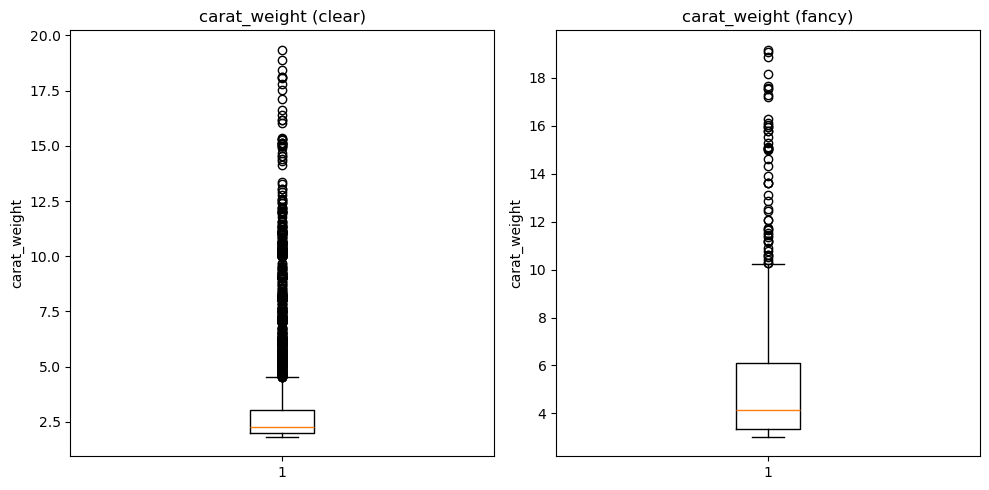

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram (price by carat weight)
ax1.boxplot(clear_high_cw['carat_weight'])
ax1.set_ylabel('carat_weight')
ax1.set_title('carat_weight (clear)')

ax2.boxplot(fancy_high_cw['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('carat_weight (fancy)')


# # Histogram (price by carat weight)
# ax2.scatter(x=fancy_diamonds['carat_weight'], y=fancy_diamonds['total_sales_price'],  edgecolor='black')
# ax2.set_xlabel('carat weight')
# ax2.set_ylabel('total sales price')
# ax2.set_title('total sales price by carat weight (fancy)')

# # Create the plot
# sns.scatterplot(x='carat_weight', y='total_sales_price', data=, hue='carat_weight', palette='viridis')

plt.tight_layout()
plt.show()

Being albe to predict clear diamond prices up to 4.5 carats and colored up to 10.25 is fine for now. If I need to I can add another one for clear. But, as a reference, let's first see what it would look like from the initial cutoff points to the full range of prices.

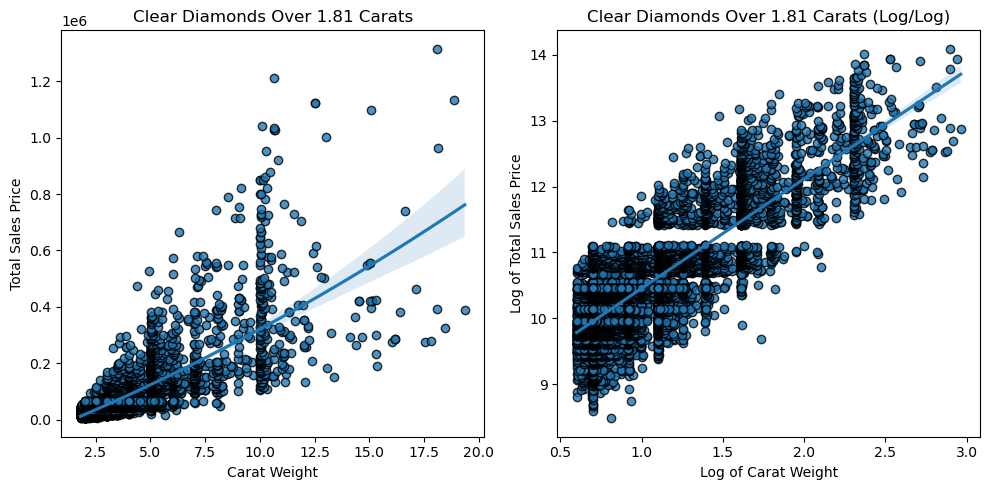

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# linear
sns.regplot(x='carat_weight', y='total_sales_price', data=clear_high_cw, ax=ax1, scatter_kws={'edgecolor':'black'},  order=2)
ax1.set_xlabel('Carat Weight')
ax1.set_ylabel('Total Sales Price')
ax1.set_title(f'Clear Diamonds Over {clear_upper_lim_carat} Carats')

# log/log
sns.regplot(x='log_cw', y='log_price', data=clear_high_cw, ax=ax2, scatter_kws={'edgecolor':'black'},  order=2)
ax2.set_xlabel('Log of Carat Weight')
ax2.set_ylabel('Log of Total Sales Price')
ax2.set_title(f'Clear Diamonds Over {clear_upper_lim_carat} Carats (Log/Log)')

plt.tight_layout()
plt.show()

In [32]:
clear_high_cw = clear_high_cw[clear_high_cw['carat_weight'] < clear_high_cutoff]
clear_high_cw.carat_weight.min(),clear_high_cw.carat_weight.max()

(np.float64(1.82), np.float64(4.53))

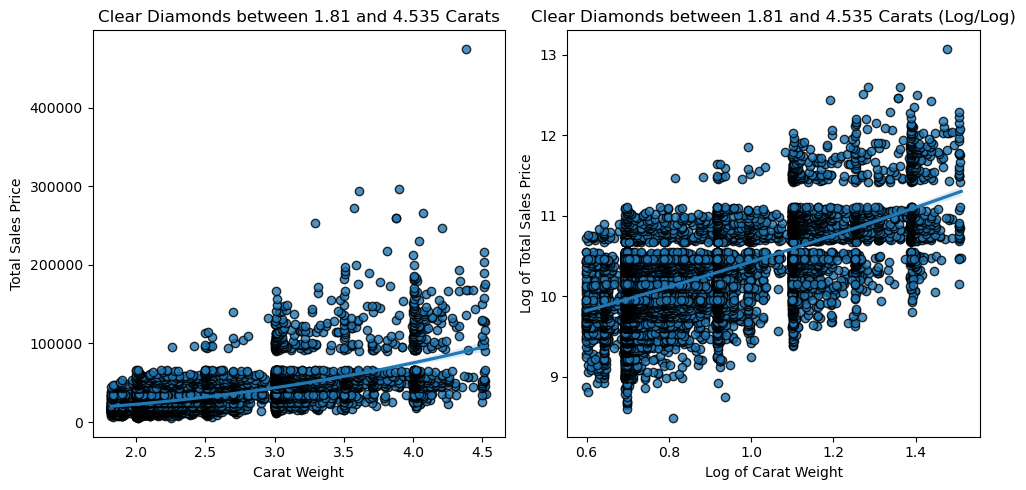

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# linear
sns.regplot(x='carat_weight', y='total_sales_price', data=clear_high_cw, ax=ax1, scatter_kws={'edgecolor':'black'},  order=2)
ax1.set_xlabel('Carat Weight')
ax1.set_ylabel('Total Sales Price')
ax1.set_title(f'Clear Diamonds between {clear_upper_lim_carat} and {clear_high_cutoff} Carats')

# log/log
sns.regplot(x='log_cw', y='log_price', data=clear_high_cw, ax=ax2, scatter_kws={'edgecolor':'black'},  order=2)
ax2.set_xlabel('Log of Carat Weight')
ax2.set_ylabel('Log of Total Sales Price')
ax2.set_title(f'Clear Diamonds between {clear_upper_lim_carat} and {clear_high_cutoff} Carats (Log/Log)')

plt.tight_layout()
plt.show()

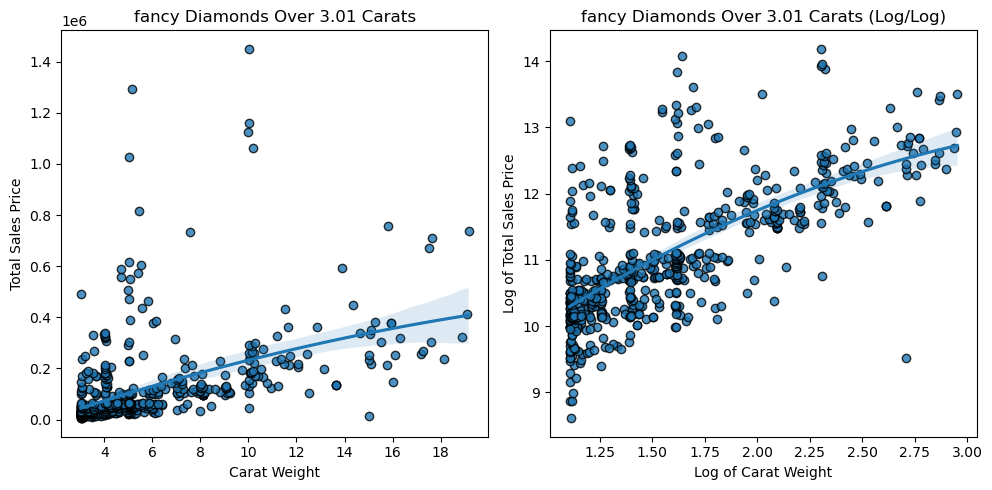

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# linear
sns.regplot(x='carat_weight', y='total_sales_price', data=fancy_high_cw, ax=ax1, scatter_kws={'edgecolor':'black'},  order=2)
ax1.set_xlabel('Carat Weight')
ax1.set_ylabel('Total Sales Price')
ax1.set_title(f'fancy Diamonds Over {fancy_upper_lim_carat} Carats')

# log/log
sns.regplot(x='log_cw', y='log_price', data=fancy_high_cw, ax=ax2, scatter_kws={'edgecolor':'black'},  order=2)
ax2.set_xlabel('Log of Carat Weight')
ax2.set_ylabel('Log of Total Sales Price')
ax2.set_title(f'fancy Diamonds Over {fancy_upper_lim_carat} Carats (Log/Log)')

plt.tight_layout()
plt.show()

In [35]:
fancy_high_cw = fancy_high_cw[fancy_high_cw['carat_weight'] < fancy_high_cutoff]
fancy_high_cw.carat_weight.min(),fancy_high_cw.carat_weight.max()

(np.float64(3.02), np.float64(10.24))

In [36]:
# And what it looks liek now

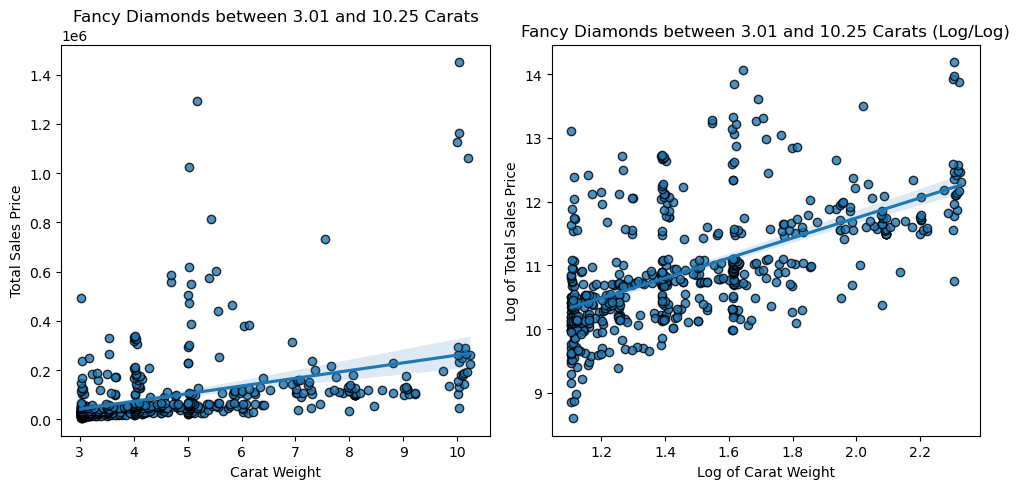

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# linear
sns.regplot(x='carat_weight', y='total_sales_price', data=fancy_high_cw, ax=ax1, scatter_kws={'edgecolor':'black'})
ax1.set_xlabel('Carat Weight')
ax1.set_ylabel('Total Sales Price')
ax1.set_title(f'Fancy Diamonds between {fancy_upper_lim_carat} and {round(fancy_high_cutoff, 2)} Carats')

# log/log
sns.regplot(x='log_cw', y='log_price', data=fancy_high_cw, ax=ax2, scatter_kws={'edgecolor':'black'})
ax2.set_xlabel('Log of Carat Weight')
ax2.set_ylabel('Log of Total Sales Price')
ax2.set_title(f'Fancy Diamonds between {fancy_upper_lim_carat} and {round(fancy_high_cutoff, 2)} Carats (Log/Log)')

plt.tight_layout()
plt.show()

In [38]:
## Sticking with models of

In [39]:
clear diamonds

In [40]:
# clear_high_Q1_carat_weight, clear_high_Q3_carat_weight = clear_high_cw ['carat_weight'].quantile(.25), clear_high_cw ['carat_weight'].quantile(.75)
# clear_high_IQR_carat_weight = clear_high_Q3_carat_weight - clear_high_Q1_carat_weight
# clear_cutoff = clear_high_Q3_carat_weight + 1.5*clear_high_IQR_carat_weight

# clear_high_cw['carat_weight'].max()

In [41]:
clear_low_cw.carat_weight.min(), clear_high_cw.carat_weight.max()
clear_high_cw.carat_weight.min(), clear_high_cw.carat_weight.max()

(np.float64(1.82), np.float64(4.53))

In [56]:
def preprocess_data(df, target_col='log_price', test_size=0.2, val_size=0.25, random_state=1):
    # Drop the 'total_sales_price' column
    df = df.drop(columns=['total_sales_price'])
    
    # Split the dataset
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size=val_size, random_state=random_state)
    
    # Reset index for training, validation, and test sets
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    # Extract target variables
    y_train = df_train.pop(target_col)
    y_val = df_val.pop(target_col)
    y_test = df_test.pop(target_col)
    
    return df_train, df_val, df_test, y_train, y_val, y_test

# Apply preprocessing for base and upper splits
clear_low_X_train, clear_low_X_val, clear_low_X_test, clear_low_y_train, clear_low_y_val, clear_low__y_test = preprocess_data(clear_low_cw)
clear_high_X_train, clear_high_X_val, clear_high_X_test, clear_high_y_train, clear_high_y_val, clear_high_y_test = preprocess_data(clear_high_cw)

In [57]:
clear_low_y_train

0         8.053887
1         7.966240
2         9.679344
3         8.408940
4         8.925055
            ...   
118118    6.931472
118119    6.486161
118120    7.981392
118121    8.208219
118122    6.822197
Name: log_price, Length: 118123, dtype: float64

In [58]:
# Define ordinal mappings for each ordinal column
ordinal_mappings = {
    'clarity': clarity_ord,
    'culet_size': culet_size_ord,
    'cut_quality': cut_quality_ord,
    'polish': polish_ord,
    'symmetry': symmetry_ord
}

# Ordinal encoder with predefined order
ordinal_transformers = [(col, OrdinalEncoder(categories=[categories]), [col]) for col, categories in ordinal_mappings.items()]

# Preprocessing for nominal columns using OneHotEncoder
nominal_transformer = ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_columns)

# Preprocessing for numerical columns
numerical_columns = ['carat_weight', 'depth_percent', 'table_percent', 'meas_length', 'meas_width', 'meas_depth']
numerical_transformer = ('numerical', Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values if any
    ('scaler', StandardScaler())  # Regularization via standardization
]), numerical_columns)

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        *ordinal_transformers,  # Add each ordinal transformer
        nominal_transformer,
        numerical_transformer
    ]
)


In [59]:
# Pipeline for model training
def get_model_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=42),
}

# Grid search parameter grids
param_grids = {
    'Linear Regression': {},
    'XGBoost': {
        'model__n_estimators': [100, 150, 200, 250],
        'model__max_depth': [4, 5, 6, 7, 8, 9, 10],
        'model__learning_rate': [0.01, .05,  0.1, 0.2]
    },
}

# Train each model with cross-validation
best_models = {}

# Wrapping the outer model loop with tqdm
for model_name, model in tqdm(models.items(), desc="Models"):
    print(f"\nTraining {model_name}...")
    pipeline = get_model_pipeline(model)
    param_grid = param_grids[model_name]

    # Wrapping GridSearchCV with tqdm for verbose cross-validation progress
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1  # Setting verbose for GridSearchCV to show internal progress
    )

    # Fitting the grid search
    grid_search.fit(clear_low_X_train, clear_low_y_train)
    best_models[model_name] = grid_search.best_estimator_

# Evaluate models on validation data
print("\nModel Evaluation:")
for model_name, model in best_models.items():
    val_score = model.score(clear_low_X_val, clear_low_y_val)
    print(f"{model_name} Validation Score: {val_score}")

Models:   0%|                                                                           | 0/2 [00:00<?, ?it/s]


Training Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Models:  50%|█████████████████████████████████▌                                 | 1/2 [00:02<00:02,  2.60s/it]


Training XGBoost...
Fitting 5 folds for each of 112 candidates, totalling 560 fits


Models: 100%|██████████████████████████████████████████████████████████████████| 2/2 [03:47<00:00, 113.69s/it]



Model Evaluation:
Linear Regression Validation Score: 0.9205992840275378
XGBoost Validation Score: 0.9921203877327398


## Oh, Hell Yes!

for reference the baseline last (combined clear and fancy with a cutoff of 2.04) was

Linear Regression Validation Score: 0.5376055997772804
XGBoost Validation Score: 0.686026930809021

And with XGBoost tuned it got to a whopping 77. So this looks good.

In [61]:
#Iprint("Best parameters for XGBoost:", best_models['XGBoost'].get_params())

Best parameters for XGBoost: {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('clarity',
                                 OrdinalEncoder(categories=[['F', 'IF', 'VVS1',
                                                             'VVS2', 'VS1',
                                                             'VS2', 'SI1',
                                                             'SI2', 'SI3', 'I1',
                                                             'I2', 'I3']]),
                                 ['clarity']),
                                ('culet_size',
                                 OrdinalEncoder(categories=[['N', 'VS', 'S',
                                                             'M', 'SL', 'L',
                                                             'VL', 'EL',
                                                             'unknown']]),
                                 ['culet_size']),
                                ('cut_quality',
 

In [64]:
# Updated evaluation function with explained variance
def evaluate_model(model, X_val, y_val):
    """
    Evaluate the model using RMSE, R², and explained variance.
    """
    predictions = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, predictions)  # Updated to use sklearn's function
    r2 = r2_score(y_val, predictions)
    evs = explained_variance_score(y_val, predictions)  # Explained variance
    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation R²: {r2:.4f}")
    print(f"Validation Explained Variance: {evs:.4f}")
    return rmse, r2, evs

# Evaluate the model on the base validation set
print("Evaluation Metrics for Best XGBoost Model:")
rmse, r2, evs = evaluate_model(best_xgb_model, baseX_val, base_y_val)

# Function to plot grid search results
def plot_grid_search_results(grid_search, param_grid):
    results = pd.DataFrame(grid_search.cv_results_)
    results['mean_test_score'] = -results['mean_test_score']  # Convert to positive RMSE

    for param in param_grid:
        if len(param_grid[param]) > 1:
            plt.figure(figsize=(10, 6))
            sns.lineplot(data=results, x=f'param_{param}', y='mean_test_score', marker='o')
            plt.title(f"Grid Search RMSE for {param}")
            plt.xlabel(param)
            plt.ylabel("Mean Test RMSE")
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()

# Call the plotting function for XGBoost results
plot_grid_search_results(xgb_random_search, xgb_params)

def plot_pca_variance(df, n_components=10):
    """
    Plot cumulative explained variance by principal components.
    """
    transformed_data = preprocessor.fit_transform(df).toarray()  # Convert to dense array
    pca = PCA(n_components=n_components)
    pca.fit(transformed_data)
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Explained Variance by Principal Components")
    plt.grid(True)
    plt.show()

# Plot PCA for base training set
plot_pca_variance(baseX_train)

importances = best_xgb_model.named_steps['model'].feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances")
plt.show()



def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Residuals Distribution")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()

# On validation set
preds = best_xgb_model.predict(baseX_val)

Evaluation Metrics for Best XGBoost Model:


NameError: name 'best_xgb_model' is not defined

There is another option of just going with 90% solution. I think this will yeild an accurate if unimpressive model

In [71]:
solution_90 = df[df['carat_weight'] <= 2.5]


In [72]:
yolo = df[df['carat_weight'] <= 5]

In [69]:
solution_90['carat_weight'].max()

np.float64(2.5)

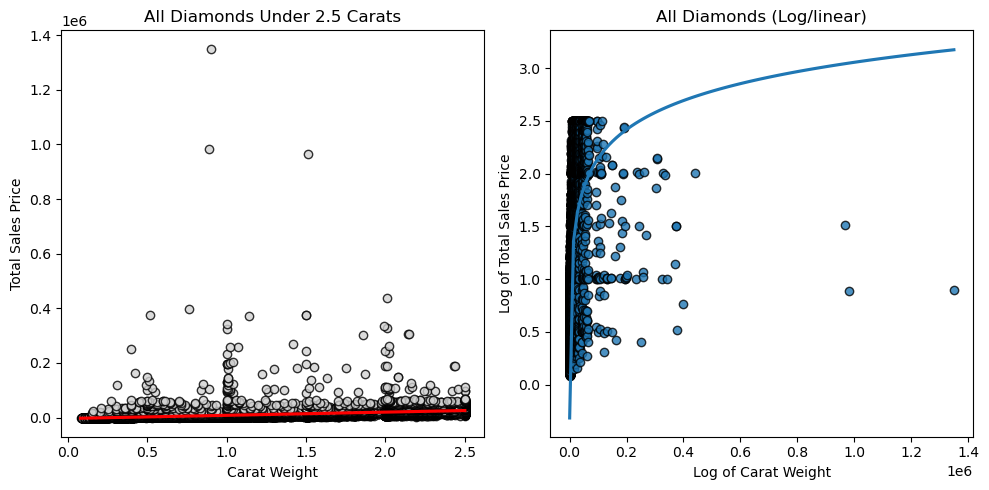

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
dot_color = 'lightgrey'
ci_color = 'red'
# linear
sns.regplot(x='carat_weight', y='total_sales_price', data=solution_90, ax=ax1, 
            scatter_kws={'color': dot_color, 'edgecolor': 'black'}, 
            line_kws={'color': 'red'}, ci=95) 
ax1.set_xlabel('Carat Weight')
ax1.set_ylabel('Total Sales Price')
ax1.set_title(f'All Diamonds Under 2.5 Carats')

# log/log
sns.regplot(y='carat_weight', x='total_sales_price', logx=True, data=solution_90, ax=ax2, scatter_kws={'edgecolor':'black'})
ax2.set_xlabel('Log of Carat Weight')
ax2.set_ylabel('Log of Total Sales Price')
ax2.set_title(f'All Diamonds (Log/linear)')

plt.tight_layout()
plt.show()

Yeah, I can work with that. I need to think about the price outliers part. The goal is to predict prices accurately. Getting rid of some outliers makes sense because they would be way overpriced. Before I commit to that, I need to see what > 2.5 stones looks like and what the difference going with the cutoff point does.

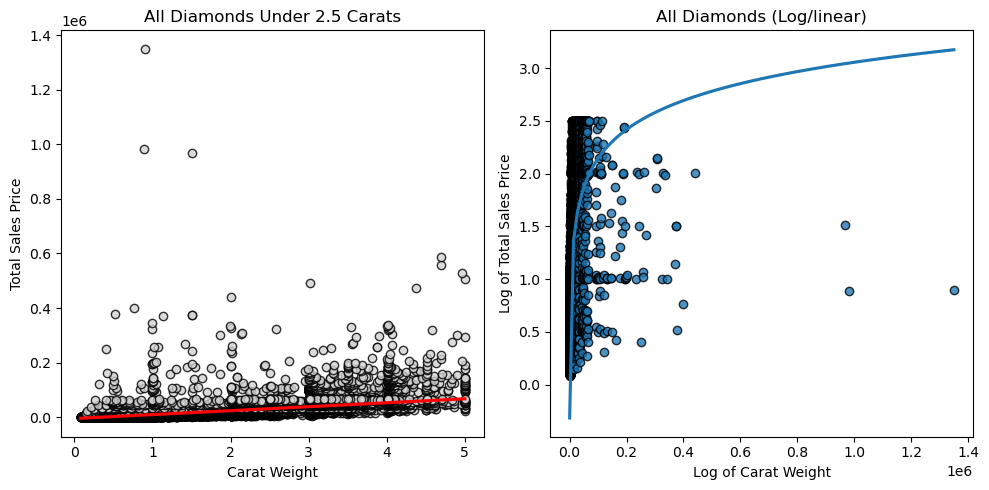

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
dot_color = 'lightgrey'
ci_color = 'red'
# linear
sns.regplot(x='carat_weight', y='total_sales_price', data=yolo, ax=ax1, 
            scatter_kws={'color': dot_color, 'edgecolor': 'black'}, 
            line_kws={'color': 'red'}, ci=95) 
ax1.set_xlabel('Carat Weight')
ax1.set_ylabel('Total Sales Price')
ax1.set_title(f'All Diamonds Under 2.5 Carats')

# log/log
sns.regplot(y='carat_weight', x='total_sales_price', logx=True, data=solution_90, ax=ax2, scatter_kws={'edgecolor':'black'})
ax2.set_xlabel('Log of Carat Weight')
ax2.set_ylabel('Log of Total Sales Price')
ax2.set_title(f'All Diamonds (Log/linear)')

plt.tight_layout()
plt.show()

In [ ]:
super_90 = df[df['carat_weight'] > 2.5]
super_90

In [ ]:
super_90['carat_weight'].min()

In [ ]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# Histogram
ax1.scatter(x=super_90['log_cw'], y=super_90['log_price'],  edgecolor='black')
ax1.set_xlabel('log of carat_weight >2.5 carats')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (>2.5)')

# Box Plot (Whiskers)
ax2.boxplot(super_90['log_cw'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (>2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

In [ ]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# Histogram
ax1.scatter(x=super_90['carat_weight'], y=super_90['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (>2.5)')

# Box Plot (Whiskers)
ax2.boxplot(super_90['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (>2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

#### What if we make it 3 models, splitting the last at the outlier cutoff?

In [ ]:
super_90.describe()

In [ ]:
top_Q1_price, top_Q3_price = super_90['total_sales_price'].quantile(.25), super_90['total_sales_price'].quantile(.75)
top_IQR_price = top_Q3_price - top_Q1_price
top_IQR_price

In [ ]:
top_upper_lim_price = top_Q3_price + 1.5*top_IQR_price
top_upper_lim_price

In [ ]:
top_Q1_carat_weight, top_Q3_carat_weight = super_90['carat_weight'].quantile(.25), super_90['carat_weight'].quantile(.75)
top_IQR_carat_weight = top_Q3_carat_weight - top_Q1_carat_weight
top_IQR_carat_weight

In [ ]:
top_upper_lim_carat_weight = top_Q3_carat_weight + 1.5*top_IQR_carat_weight
top_upper_lim_carat_weight

In [ ]:
tippy_top_price = df[df['total_sales_price'] < 202460]

In [ ]:
tippy_top_cw = df[df['carat_weight'] > 8.01]

In [ ]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# Histogram
ax1.scatter(x=tippy_top_cw['carat_weight'], y=tippy_top_cw['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (>2.5)')

# Box Plot (Whiskers)
ax2.boxplot(tippy_top_cw['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (>2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

In [ ]:
tippy_top_cw.describe()

In [ ]:
approx10c = df[(df['carat_weight'] > 9.9) & (df['carat_weight'] <= 10.15)]

In [ ]:
approx10c

In [ ]:
approx10c['total_sales_price'].min()

In [ ]:
approx10c['total_sales_price'].max()

### Let's take a step back

The goal here is to make a model that will give decently accurate price predictions for stones for jewelry. And probably that's something like an engagement ring as, unlike earrings, they tend to stay on. But there is a 30 fold varitation in the price of a 10 carat diamond that runs between a moderately priced car and either a rather nice car and a rather nice house in pretty well off area. But we way past what most people could afford. 

## What we have so far
So far we have the original linear charts of price/cw and a box and whiskers of carat weights [9].
Filtering it was of limited value [20, 21]
log-log of price-carat weights [26] was where we could see definite improvements. 

##### So at that point we knew we needed log-log but we need find cut off points. Either one model using IQR, or past the IQR, or two models of below an IQR cutoff and then a second one.

the 90% solution (cutoff at 2.5 cw) looked pretty good. Diamonds above were ok. Splitting it again so that were 3 models didn't help.

### Now what?
We're going to repeat this with the cutoff at the oulier point. 


In [ ]:
under_outlier = df[df['carat_weight'] < upper_lim_carat_weight]
under_outlier

In [ ]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
ax1.scatter(x=under_outlier['log_cw'], y=under_outlier['log_price'],  edgecolor='black')

#ax1.scatter(x=df['carat_weight'], y=df['log_price'],  edgecolor='black')


# Histogram
ax1.scatter(x=under_outlier['log_cw'], y=under_outlier['log_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (<2.5)')

# Box Plot (Whiskers)
ax2.boxplot(under_outlier['log_cw'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (<2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()


In [ ]:
outlier = df[df['carat_weight'] > upper_lim_carat_weight]

In [ ]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
ax1.scatter(x=outlier['log_cw'], y=outlier['log_price'],  edgecolor='black')


# Histogram
ax1.scatter(x=outlier['log_cw'], y=outlier['log_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (>2.5)')

# Box Plot (Whiskers)
ax2.boxplot(outlier['log_cw'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (>2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

OK, I'm satisfied with this. I think the only think I have to verify is that there are none above this extended range.


In [ ]:
extended_Q1_carat_weight, extended_Q3_carat_weight = outlier['carat_weight'].quantile(.25), outlier['carat_weight'].quantile(.75)
extended_IQR_carat_weight = extended_Q3_carat_weight - extended_Q1_carat_weight
extended_IQR_carat_weight

In [ ]:
extended_upper_lim_carat_weight = extended_Q3_carat_weight + 1.5*extended_IQR_carat_weight
extended_upper_lim_carat_weight

So, all put together, the model will predice diamonds up (we're going to round down here) up to 6.25 carats. 

In [ ]:
total_diamonds = len(df)
diamonds_above_6_25 = len(df[df['carat_weight'] > 6.25])
percentage_above_6_25 = (diamonds_above_6_25 / total_diamonds) * 100
print(f"{percentage_above_6_25:.2f}% of diamonds are above 6.25 carats.")

Considering again the YOLO cutoff point, what would that look like?

In [ ]:
upper_lim_carat_weight

In [ ]:
remaining =  df[df['carat_weight'] > upper_lim_carat_weight]
len(remaining)

In [ ]:
# Assuming your DataFrame is named 'df'
total_diamonds = len(df)
diamonds_above_2_035 = len(remaining)
percentage_above_2_035 = (diamonds_above_2_035 / total_diamonds) * 100

print (f" {round(percentage_above_2_035, 3)} percent of {len(df)} stones are diamonds above {round(upper_lim_carat_weight, 2)} carats")

## Preparing the model 

In [ ]:
### Drop rows where carat_weight is above 2.04

In [ ]:
df = pd.read_parquet("../data/diamonds.parquet")

In [ ]:
df = df[df.carat_weight <= 6.25]
df

In [ ]:
main_group = df[df.carat_weight <=2.04]

In [ ]:
extended_group = df[df.carat_weight > 2.04]

In [ ]:
main_group['carat_weight'].describe()

In [ ]:
extended_group['carat_weight'].describe()

OK, were going to work with just the `main_group` right after we confirm everything is split correctly.

In [ ]:
def preprocess_data(df, target_col='total_sales_price', test_size=.2, val_size=0.25, random_state=1):
    """
        Preprocess the dataset by splitting it into training, validation, and test sets, 
        and separating the target variable. Default is 60/20/20 split
    
        Parameters:
        df (pd.DataFrame): The input dataframe containing the dataset.
        target_col (str): The name of the target column. Default is 'y'.
        test_size (float): The proportion of the dataset to include in the test split. Default is 0.2.
        val_size (float): The proportion of the training set to include in the validation split. Default is 0.25.
        random_state (int): The random seed used for shuffling the data. Default is 42.
    
        Returns:
        tuple: A tuple containing:
            - df_train (pd.DataFrame): The training set with the target column removed.
            - df_val (pd.DataFrame): The validation set with the target column removed.
            - df_test (pd.DataFrame): The test set with the target column removed.
            - y_train (pd.Series): The target values for the training set.
            - y_val (pd.Series): The target values for the validation set.
            - y_test (pd.Series): The target values for the test set.
        """
    
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size=val_size, random_state=random_state)
    
    # Reset indices and separate target variable
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.pop(target_col)
    y_val = df_val.pop(target_col)
    y_test = df_test.pop(target_col)
    
    return df_train, df_val, df_test, y_train, y_val, y_test

# Example usage:
#df_train, df_val, df_test, y_train, y_val, y_test = preprocess_data(df, target_col='jamb_score', random_state=1)


In [ ]:
df_train, df_val, df_test, y_train, y_val, y_test = preprocess_data(main_group, target_col='total_sales_price', test_size=.2, val_size=0.25, random_state=1)

In [ ]:
len(df_train), len(df_val), len(df_test)

In [ ]:
ex_df_train, ex_df_val, ex_df_test, ex_y_train, ex_y_val, ex_y_test = preprocess_data(extended_group, target_col='total_sales_price', test_size=.2, val_size=0.25, random_state=1)

In [ ]:
len(ex_df_train), len(ex_df_val), len(ex_df_test)

In [ ]:
## Make and run the pipeline

In [ ]:
# nominal_pipeline = Pipeline(
#     steps=[("onehot", OneHotEncoder(handle_unknown="ignore")) ])
 
# clarity_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

# culet_size_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

# cut_quality_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

# polish_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

# symmetry_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Define ordinal mappings for each ordinal column
ordinal_mappings = {
    'clarity': clarity_ord,
    'culet_size': culet_size_ord,
    'cut_quality': cut_quality_ord,
    'polish': polish_ord,
    'symmetry': symmetry_ord
}

# Ordinal encoder with predefined order
ordinal_transformers = [(col, OrdinalEncoder(categories=[categories]), [col]) for col, categories in ordinal_mappings.items()]

# Preprocessing for nominal columns using OneHotEncoder
nominal_transformer = ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_columns)

# Preprocessing for numerical columns
numerical_columns = ['carat_weight', 'depth_percent', 'table_percent', 'meas_length', 'meas_width', 'meas_depth']
numerical_transformer = ('numerical', Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values if any
    ('scaler', StandardScaler())  # Regularization via standardization
]), numerical_columns)

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        *ordinal_transformers,  # Add each ordinal transformer
        nominal_transformer,
        numerical_transformer
    ]
)


In [ ]:

# # Pipeline for model training
# def get_model_pipeline(model):
#     return Pipeline([
#         ('preprocessor', preprocessor),
#         ('model', model)
#     ])

# # Define models
# models = {
#     'Linear Regression': LinearRegression(),
#     'XGBoost': XGBRegressor(random_state=42),
#     'Random Forest': RandomForestRegressor(random_state=42),

# }

# # Grid search parameter grids
# param_grids = {
#     'Linear Regression': {},
#     'XGBoost': {
#         'model__n_estimators': [100, 200],
#         'model__max_depth': [3, 6],
#         'model__learning_rate': [0.01, 0.1, 0.2]
#     },
#     'Random Forest': {
#         'model__n_estimators': [100, 200],
#         'model__max_depth': [10, 20, None]
#     },
# }

# # Train each model with cross-validation
# best_models = {}

# # Wrapping the outer model loop with tqdm
# for model_name, model in tqdm(models.items(), desc="Models"):
#     print(f"\nTraining {model_name}...")
#     pipeline = get_model_pipeline(model)
#     param_grid = param_grids[model_name]

#     # Wrapping GridSearchCV with tqdm for verbose cross-validation progress
#     grid_search = GridSearchCV(
#         pipeline,
#         param_grid,
#         cv=5,
#         scoring='neg_mean_squared_error',
#         n_jobs=-1,
#         verbose=1  # Setting verbose for GridSearchCV to show internal progress
#     )

#     # Fitting the grid search
#     grid_search.fit(df_train, y_train)
#     best_models[model_name] = grid_search.best_estimator_

# # Evaluate models on validation data
# print("\nModel Evaluation:")
# for model_name, model in best_models.items():
#     val_score = model.score(df_val, y_val)
#     print(f"{model_name} Validation Score: {val_score}")


## Results from above cell:

Models:   0%|                                                                            | 0/3 [00:00<?, ?it/s]


Training Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Models:  33%|██████████████████████▋                                             | 1/3 [00:04<00:09,  4.60s/it]


Training XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Models:  67%|█████████████████████████████████████████████▎                      | 2/3 [00:18<00:10, 10.29s/it]


Training Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Models: 100%|████████████████████████████████████████████████████████████████| 3/3 [2:35:02<00:00, 3100.87s/it]


Model Evaluation:
Linear Regression Validation Score: 0.6199830269332955 <br>
XGBoost Validation Score: 0.7835074067115784 <br>
Random Forest Validation Score: 0.7533094016655786 <br>


In [ ]:
# print("Best parameters for XGBoost:", best_models['XGBoost'].get_params())

In [ ]:
# from sklearn.metrics import root_mean_squared_error, r2_score

# # Calculate RMSE and R-squared for each model on the validation set
# print("Validation Scores (RMSE and R-squared):")
# for model_name, model in best_models.items():
#     y_pred = model.predict(df_val)

#     #scoring
#     rmse = root_mean_squared_error(y_val, y_pred)
#     r2 = r2_score(y_val, y_pred)
    
#     print(f"{model_name}:")
#     print(f"  RMSE: {rmse:.2f}")
#     print(f"  R-squared: {r2:.2f}")


Given the amount of time it took (2-2/2 hours) to run the Random Forrest and how it was better than LR but not as good as XBG, I'm going to eliminate it but keep LR as a baseline. We still have the other 

In [ ]:
ex_train, ex_val, ex_test, ex_y_train, ex_y_val, ex_y_test = preprocess_data(extended_group, target_col='total_sales_price', test_size=.2, val_size=0.25, random_state=1)

In [ ]:
# Pipeline for model training
def get_model_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=42),
}

# Grid search parameter grids
param_grids = {
    'Linear Regression': {},
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.01, 0.1, 0.2]
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None]
    },
}

# Train each model with cross-validation
best_models = {}

# Wrapping the outer model loop with tqdm
for model_name, model in tqdm(models.items(), desc="Models"):
    print(f"\nTraining {model_name}...")
    pipeline = get_model_pipeline(model)
    param_grid = param_grids[model_name]

    # Wrapping GridSearchCV with tqdm for verbose cross-validation progress
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1  # Setting verbose for GridSearchCV to show internal progress
    )

    # Fitting the grid search
    grid_search.fit(ex_train, ex_y_train)
    best_models[model_name] = grid_search.best_estimator_

# Evaluate models on validation data
print("\nModel Evaluation:")
for model_name, model in best_models.items():
    val_score = model.score(ex_val, ex_y_val)
    print(f"{model_name} Validation Score: {val_score}")

# A few hours later ...

### Tuning got it to validation RMSE: 3938.5031 and Validation R²: 0.7681 which does not seem all that impressive.
### I think maybe breaking out the fancy stones would be helpful

In [ ]:
fancy_diamonds

In [ ]:
clear_diamonds

### First question. Did I get them all?

### So, basically yes. Now for the fancy diamonds. Are there any that are color graded?

## No oddities. Nice! 
#### OK, now lets' plot the two price by carat weight for the two for the entire range, side by side

In [ ]:
## Let's compare that to the origional set

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram (price by carat weight)

ax1.scatter(x=df['carat_weight'], y=df['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat weight')
ax1.set_ylabel('total sales price')
ax1.set_title('total sales price by carat weight')

# Box Plot (Whiskers)
ax2.boxplot(df['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('Box Plot of carat_weight')

# Create the plot
sns.scatterplot(x='carat_weight', y='total_sales_price', data=df, hue='carat_weight', palette='viridis')

plt.tight_layout()
plt.show()

Hmmm. I need another notebook. Basically, this is too long. And while it shows the process, it would lack explanative power. So instead I'll end up making another notebook where all the right steps are taken with no extraneous material because it has the explanative power but at the cost of the fiction of all the 'expaoration' 